In [1]:
import numpy as np
import random
import networkx as nx
import math
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def setup_network(num_fake,num_real,num_connections,weight_given_to_news_sources,weight_for_significant_others, random_grouping, flip):
    number_of_people = 4039
    rep_news = list(range(4039,4039+int((num_fake+num_real)/2.0)))
    dem_news = list(range(4039+int((num_fake+num_real)/2.0),4039+(num_fake+num_real)))       
    
    W = np.zeros([number_of_people+num_real+num_fake,number_of_people+num_real+num_fake])

    fb_connections = np.loadtxt('facebook_combined.txt', delimiter = " ")
    fb_con = {}
    for i in fb_connections:
        try:
            fb_con[int(i[0])].append(int(i[1]))
        except:
            fb_con[int(i[0])] = [int(i[1])]

        try:
            fb_con[int(i[1])].append(int(i[0]))
        except:
            fb_con[int(i[1])] = [int(i[0])]

    for i in fb_con:
        connections = fb_con[i]
        for j in connections:
            W[i,j] = 1
            
            
    if random_grouping == 1:
        #determine republican, independent and democratic people
        #40.9% call themselves liberal, 28.4% moderate, and 30.7% call themselves conservative 
        parties = list(range(number_of_people))
        np.random.shuffle(parties)

        democrats = parties[:int(len(parties)*(0.409))]
        republicans = parties[int(len(parties)*(0.409)):int(len(parties)*(0.409+0.284))]
        moderates = parties[int(len(parties)*(0.409+0.284)):]
        ###########
    
    if random_grouping == 2: # not random, using HOMOPHILY setting!
        
        def helper(total_network,n,max_num):
            current_party = [random.randint(0,n)]
            for i in current_party:
                for j in range(0,n):
                    if (total_network[i,j] == 1) and (j not in current_party): 
                        current_party.append(j)

                        if len(current_party) >= max_num:
                            return current_party
        
        
        if (flip == 0):
            num_repub = int(number_of_people*(0.307+0.284/2.0))
            republicans = helper(W,number_of_people,num_repub)
            parties = list(range(number_of_people)) 
            democrats = [item for item in parties if item not in republicans]

        else:
            num_dem = int(number_of_people*(.409+(.284/2.0)))
            democrats = helper(W,number_of_people,num_dem)
            parties = list(range(number_of_people)) 
            republicans = [item for item in parties if item not in democrats]
           
       
        # assigning the moderates randomly - using 14.2% from each group (republicans and democrats)        
        np.random.shuffle(republicans)
        moderates = republicans[:int(number_of_people*(0.142))]
        republicans = republicans[int(number_of_people*(0.142)):]
        
        np.random.shuffle(democrats)
        listMod = democrats[:int(number_of_people*(0.142))]
        moderates = moderates + listMod
        democrats = democrats[int(number_of_people*(0.142)):]
        
    
    #print ("% of Democrats:", len(democrats)/float(len(parties)))
    #print ("% of Republicans:", len(republicans)/float(len(parties)))
    #print ("% of Moderates:", len(moderates)/float(len(parties)))
    #print ("Everyone assigned a party?", len(moderates)+len(democrats)+len(republicans) == number_of_people)
    assert(len(moderates)+len(democrats)+len(republicans) == number_of_people)
    #print ("News sources all assigned?",len(rep_news)+len(dem_news) == num_fake+num_real)
        
            
    #Add News connections based on party affiliation 
    for i in range(number_of_people):
        if i in republicans:
            if len(rep_news) > num_connections:
                c = [rep_news[a] for a in np.random.choice(list(range(len(rep_news))),num_connections,replace = False)]
            else:
                c = rep_news

        elif i in democrats:
            if len(dem_news) > num_connections:
                c = [dem_news[a] for a in np.random.choice(list(range(len(dem_news))),num_connections,replace = False)]
            else:
                c = dem_news
        else:
            all_news = rep_news+dem_news
            if len(all_news) > num_connections:
                c = [all_news[a] for a in np.random.choice(list(range(len(all_news))),num_connections,replace = False)]
            else:
                c = all_news

        for j in dem_news:
            if j not in c:
                W[i,j] = 0
            else:
                W[i,j] = 1

        for j in rep_news:
            if j not in c:
                W[i,j] = 0
            else:
                W[i,j] = 1


    #for i in range(number_of_people):
    #    assert sum(W[i,4039:]) == num_connections
    #print "People connections to news set properly"

    #for i in range(number_of_people, number_of_people+num_fake+num_real):
    #    assert sum(W[i,:]) == 0
    #print "News sources do not have connections to other news/people "
    
    return W, democrats, republicans, moderates, rep_news, dem_news

In [3]:
def A_matrix(num_fake, num_real, A_setting):
    n = 4039
    A_matrix = np.zeros([n+num_real+num_fake,n+num_real+num_fake])
    
    if A_setting == 'moderate':
        for i in range(n):
            A_matrix[i,i] = np.random.normal(loc= 0.5, scale=0.1)
            if A_matrix[i,i] > 1:
                A_matrix[i,i] = 1
            if A_matrix[i,i] < 0:
                A_matrix[i,i] = 0
                
    elif A_setting == 'open':
        for i in range(n):
            A_matrix[i,i] = np.random.normal(loc= 0.85, scale=0.05)
            if A_matrix[i,i] > 1:
                A_matrix[i,i] = 1
                
    elif A_setting == 'extremely_open':
        for i in range(n):
            A_matrix[i,i] = 1.0
            
    elif A_setting == 'closed0.4':
        for i in range(n):
            A_matrix[i,i] = np.random.normal(loc= 0.4, scale=0.1)
            if A_matrix[i,i] > 1:
                A_matrix[i,i] = 1
            if A_matrix[i,i] < 0:
                A_matrix[i,i] = 0
                
    elif A_setting == 'closed0.3':
        for i in range(n):
            A_matrix[i,i] = np.random.normal(loc= 0.3, scale=0.1)
            if A_matrix[i,i] > 1:
                A_matrix[i,i] = 1
            if A_matrix[i,i] < 0:
                A_matrix[i,i] = 0
                
    elif A_setting == 'closed0.2':
        for i in range(n):
            A_matrix[i,i] = np.random.normal(loc= 0.2, scale=0.1)
            if A_matrix[i,i] > 1:
                A_matrix[i,i] = 1
            if A_matrix[i,i] < 0:
                A_matrix[i,i] = 0
    else:
        print("Not a valid openness setting")
    
    #set news openness to zero
    for i in range(n,A_matrix.shape[0]):
        A_matrix[i,i] = 0
    return A_matrix

In [15]:
def W_matrix(W, num_fake, num_real, weight_given_to_news_sources,weight_for_significant_others, X_0):
    number_of_people = 4039
    for i in range(number_of_people):
        connections = list(np.nonzero(W[i,:4039] != 0)[0])
        if X_0[i] > 0.5:# democrat
            in_party_connections = [n for n in connections if X_0[n] > 0.5]
        else:
            in_party_connections = [n for n in connections if X_0[n] <= 0.5]
        other_connections = [n for n in connections if n not in in_party_connections]
        
        #give weight to yourself
        W[i,i] = 1-A[i,i]
        total_weight_to_give = A[i,i]
        weight_given = W[i,i]
        
        #assign weight to news connections
        news_connections = list(np.nonzero(W[i,4039:] != 0)[0])
        for a in news_connections:
            W[i,4039+a] = weight_given_to_news_sources*total_weight_to_give
            weight_given += weight_given_to_news_sources*(total_weight_to_give)
            
        #assign weight to significant others
        #if have 2 or less totally connections, assign leftover weight equally 
        if len(in_party_connections) == 0:
            weight_left = 1 - weight_given
            a = [random.random() for _ in range(len(connections))]
            b = [weight_left*aa/float(sum(a)) for aa in a]
            for aa in range(len(b)):
                W[i,connections[aa]] = b[aa]
            W[i,connections[aa]] = b[aa]-10**(-12) 
            
        #if 0 weight is being given to significant others, they are regular connections 
        elif weight_for_significant_others == 0:
            weight_left = 1 - weight_given
            a = [random.random() for _ in range(len(in_party_connections))]
            b = [weight_left*aa/float(sum(a)) for aa in a]
            for aa in range(len(in_party_connections)):
                W[i,in_party_connections[aa]] = b[aa]
            W[i,in_party_connections[aa]] = b[aa]-10**(-12)
            
            for o in other_connections:
                W[i,o] = 0
            
        elif len(in_party_connections) <= 2:
            weight_left = 1 - weight_given
            a = [random.random() for _ in range(len(in_party_connections))]
            b = [weight_left*aa/float(sum(a)) for aa in a]
            for aa in range(len(b)):
                W[i,in_party_connections[aa]] = b[aa]
            W[i,in_party_connections[aa]] = b[aa]-10**(-12)   
            
            for o in other_connections:
                W[i,o] = 0
            
        #if there are greater than 2 connections, pick two to give the assigned weight to
        #then assign all the other connections equally 
        elif len(in_party_connections) > 2:
            signif_others = [in_party_connections[a] for a in np.random.choice(list(range(len(in_party_connections))),2,replace = False)]
            
            con = [c for c in in_party_connections if c not in signif_others]
            for j in signif_others:
                W[i,j] = weight_for_significant_others*total_weight_to_give
                weight_given += weight_for_significant_others*total_weight_to_give

            weight_left = 1 - weight_given

            a = [random.random() for _ in range(len(con))]
            b = [weight_left*aa/float(sum(a)) for aa in a]
            for aa in range(len(con)):
                W[i,con[aa]] = b[aa]
            W[i,con[aa]] = b[aa]-10**(-12)
            
            for o in other_connections:
                W[i,o] = 0
                
#         check = True
#         if sum(W[i,:]) > 1:
#             check = False
#         if round(sum(W[i,:]),4) != 1:
#             check = False
#         assert(check == True)
            
    #set weights for news sites to themselves
    for i in range(number_of_people, number_of_people+num_fake+num_real):
        W[i,i] = 1
        
    #####CHECKING CODE
    check = True
    for i in range(number_of_people+num_fake+num_real):
        if sum(W[i,:]) > 1:
            check = False
        if round(sum(W[i,:]),4) != 1:
            check = False
    print("All rows sum to 1 and are not greater than 1:", check)
    assert(check == True)
    return W
        

In [5]:
def X_0_Matrix(num_fake,num_real,democrats,republicans,moderates, rep_news, dem_news):
    number_of_people = 4039
    X_0 = np.zeros([number_of_people+num_fake+num_real,1])

    #Define people's beliefs
    #if democrat, 66% support [0.5,1]
    support_dems = democrats[:int(len(democrats)*0.66)]
    for i in democrats:
        if i in support_dems:
            X_0[i] = np.random.normal(loc= 0.8, scale=0.1)
        else:
            X_0[i] = np.random.normal(loc= 0.45, scale=0.02)

        if X_0[i] > 1:
            X_0[i] = 1
        elif X_0[i] < 0:
            X_0[i] = 0

    #if republican, 36% support
    support_repub = republicans[:int(len(republicans)*0.36)]
    for i in republicans:
        if i in support_repub:
            X_0[i] = np.random.normal(loc= 0.55, scale=0.02)
        else:
            X_0[i] = np.random.normal(loc= 0.2, scale=0.1)

        if X_0[i] > 1:
            X_0[i] = 1
        elif X_0[i] < 0:
            X_0[i] = 0

    #if moderate, 54% support
    support_ind = moderates[:int(len(moderates)*0.54)]
    for i in moderates:
        if i in support_ind:
            X_0[i] = np.random.normal(loc= 0.55, scale=0.02)
        else:
            X_0[i] = np.random.normal(loc= 0.45, scale=0.02)

        if X_0[i] > 1:
            X_0[i] = 1
        elif X_0[i] < 0:
            X_0[i] = 0


    fake = [i for i in np.random.choice(list(range(num_fake+num_real)),num_fake,replace = False)]

    for n in range(num_fake+num_real):
        if n in fake:
            if 4039+n in rep_news:
                X_0[4039+n] = 0.1*np.random.random()
            elif 4039+n in dem_news:
                X_0[4039+n] = 0.1*np.random.random()+0.9

        else:
            if 4039+n in rep_news:
                X_0[4039+n] = 0.5*np.random.random()
            elif 4039+n in dem_news:
                X_0[4039+n] = 0.5*np.random.random()+0.5

                
    d = []
    r = []
    m = []
    for i in range(4039):
        if i in moderates:
            if X_0[i] >= 0.5: #if they support abortion
                m.append(1)
            else:
                m.append(0)
        if i in democrats:
            if X_0[i] >= 0.5: #if they support abortion
                d.append(1)
            else:
                d.append(0)
        if i in republicans:
            if X_0[i] >= 0.5: #if they support abortion
                r.append(1)
            else:
                r.append(0)
                
    print(sum(m)/float(len(m)),sum(d)/float(len(d)),sum(r)/float(len(r)))
    ####Check
#     check = True
#     for i in range(len(X_0)):
#         if X_0[i] < 0 or X_0[i] > 1:
#             check = False
#     print "All starting beliefs are valid:", check
    
    return X_0

In [6]:
# Constructing the new X matrix
def update_beliefs(A_matrix, W_matrix, x_current, X_0):
    first_two = np.dot(A_matrix,W_matrix)
    second_two = np.dot(first_two, x_current)
    I = np.eye((A_matrix).shape[0])
    next_x = np.add(second_two,np.dot(np.subtract(I,A_matrix),X_0))
    return next_x

In [17]:
def test(A,W,X_0,tol,moderates,republicans,democrats,plot_name):
    count = 0

    X = X_0
    X_new = update_beliefs(A, W, X, X_0)

    belief_results =  [X_0, X_new]

    while np.linalg.norm(np.subtract(X,X_new)) > tol:
        X = X_new
        count += 1
        X_new = update_beliefs(A, W, X, X_0)
        flag = False
        for i in X_new:
            if i[0] > 1.0 or i[0] < 0:
                print("Problem")
                flag = True

        belief_results.append(X_new)
    d = []
    r = []
    m = []
    for i in range(4039):
        if i in moderates:
            if X_new[i] >= 0.5: #if they support abortion
                m.append(1)
            else:
                m.append(0)
        if i in democrats:
            if X_new[i] >= 0.5: #if they support abortion
                d.append(1)
            else:
                d.append(0)
        if i in republicans:
            if X_new[i] >= 0.5: #if they support abortion
                r.append(1)
            else:
                r.append(0)
                
    print([sum(m)/float(len(m)),sum(d)/float(len(d)),sum(r)/float(len(r))])
    ###Save the plot
    ppl = []
    for p in range(4039):
        person = []
        for l in range(len(belief_results)):
            person.append(belief_results[l][p])
        ppl.append(person)

    fig = plt.figure(figsize=(5,5))

    for i in range(len(ppl)):
        plt.plot(ppl[i],'b-', alpha=0.07)
    
    all_news = []
    for n in range(4039,len(belief_results[0])):
        news = []
        for l in range(len(belief_results)):
            news.append(belief_results[l][n])
        all_news.append(news)

    for i in range(len(all_news)):
        plt.plot(all_news[i],'r-', alpha=0.5)
        
    plt.savefig("Plots/"+plot_name+".png")
    plt.close(fig)

    return count, d, r, m

# Code for Testing Over Parameter Space

0.5349040139616056 0.6588021778584392 0.3604838709677419
All rows sum to 1 and are not greater than 1: True
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

ValueError: object too deep for desired array

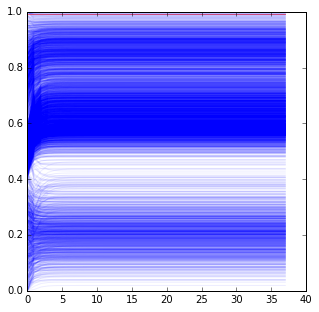

In [18]:
import csv

tol = 10**(-10)

openness = 'moderate'
# random_grouping = 1 #this means the original graph with no political groupings
random_grouping = 2 #this means the original graph with political groupings (homophily setting)

results = []
parameters = []
belief_percentages = []

number_of_iterations  = 0
for num_fake in [0,15,30]:
    for num_real in [1,15,25]:
        for weight_for_significant_others in [0,0.2,0.4]:
            for num_connections in [1,6,10]:
                if num_connections > num_fake+num_real:
                    break
                else:
                    for flip in [0,1]:
                        weight_given_to_news_sources = (0.8-2*weight_for_significant_others)/float(num_connections)

                        for trial_number in range(5):
                            
                            W, democrats, republicans, moderates, rep_news, dem_news = setup_network(num_fake,num_real,num_connections,weight_given_to_news_sources,weight_for_significant_others, random_grouping, flip)
                            A = A_matrix(num_fake,num_real,openness)
                            X_0 = X_0_Matrix(num_fake,num_real,democrats,republicans,moderates, rep_news, dem_news )
                            W = W_matrix(W, num_fake, num_real, weight_given_to_news_sources ,weight_for_significant_others, X_0)

                            plot_name = 'Openness='+str(openness)+"_Fake"+str(num_fake)+"_Real"+str(num_real)+"_SigWeight"+str(weight_for_significant_others)+"_NumConnect"+str(num_connections)+"_Trial"+str(trial_number)
                            count, d, r, m = test(A,W,X_0,tol,moderates,republicans,democrats,plot_name)

                            parameters.append([num_fake,num_real,weight_for_significant_others,weight_given_to_news_sources,num_connections, flip, trial_number])
                            results.append([openness,num_fake,num_real,weight_for_significant_others,weight_given_to_news_sources,num_connections, flip, trial_number, count])
                            belief_percentages.append([sum(m)/float(len(m)),sum(d)/float(len(d)),sum(r)/float(len(r))])
                            
                            number_of_iterations += 1
                            
                            if number_of_iterations %100 == 0:
                                print(number_of_iterations/100.0)
                                
                                #this block will write out the # of iterations for each parameter option to a file
                                with open('Simulation_resultsHomophily2_'+str(openness)+str(number_of_iterations /100)+'.csv', 'w') as f:
                                    writer = csv.writer(f)
                                    writer.writerow(["Openness","#fake news","#news","Significant other weight","News weight","News connections",'Flip',"Trial number","Iterations until convergence",'Moderates','Democrats','Republicans'])
                                    for i in range(len(results)):
                                        writer.writerow(results[i]+belief_percentages[i])
                      
                    
with open('Simulation_resultsHomophily2_'+str(openness)+'.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Openness","#fake news","#news","Significant other weight","News weight","News connections",'Flip',"Trial number","Iterations until convergence",'Moderates','Democrats','Republicans'])
    for i in range(len(results)):
        writer.writerow(results[i]+belief_percentages[i])